# Autoencoders and VAEs

Learning Outcomes:
- Apply AEs and VAEs to different tasks: image compression and image generation.
- Visualize the latent space.
- Evaluate the impact of different regularization functions and hyper-parameters on the latent representations.
- Generate images and interpolate between images using the VAE.
- Transfer the learnt representation for use in supervised tasks.

## Library Imports

In [87]:
%load_ext autoreload
%autoreload 2

import random

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


## The MNIST dataset
The MNIST dataset consists of **70,000 grayscale images** of handwritten digits (0 to 9). Each image is a **28x28 pixel** grayscale image. The training set contains 60,000 images while the test set contains 10,000 images. The grayscale values are integers ranging from 0 (black) to 255 (white). However, typicially the data is normalized to range between 0 and 1 for deep learning models.

The MNIST dataset can be downloaded from the **torchvision** library, using the following code:

In [88]:
# Load the MNIST dataset
transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

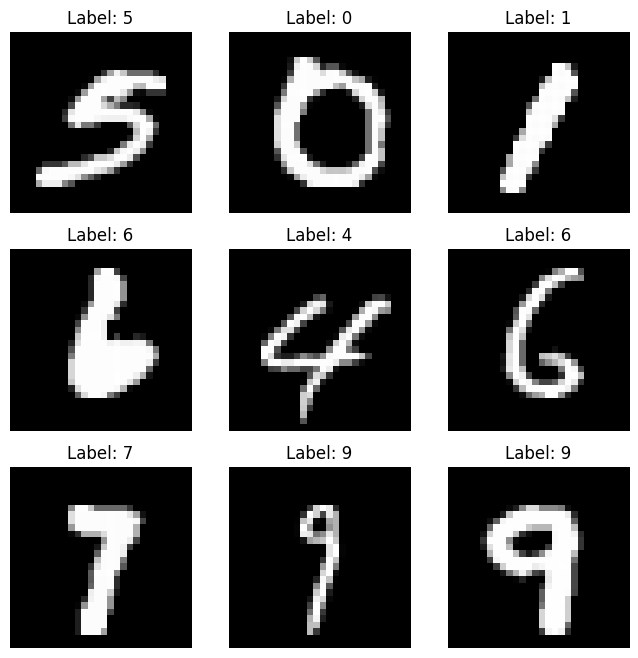

In [89]:
# Plot 9 random images from the MNIST train dataset
def plot_images(img_dataset):
    """Plots 9 random images from the given dataset

    Args:
        img_dataset (torch.utils.data.Dataset): The dataset to plot images from
    """
    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)

**Exercise.** The models that we will be using in this notebook will mainly consist of fully connected layers and activations (no convolutions). Prepare the data for use with such models (complete all the `TODO` flags below):
1. Flatten the data.
2. Normalize pixel values to the interval $[0, 1]$.

In [90]:
# Flatten the images
train_dataset = train_dataset.data.view( , ).float() # TODO: Complete with the appropriate dimensions
train_dataset = # TODO: Normalize pixel values.

# TODO: Repeat the same for the test dataset

SyntaxError: invalid syntax (3339434928.py, line 2)

In [91]:
# %load solutions/prepare_data.py
# Flatten the images
train_dataset = train_dataset.data.view(-1, 28*28).float()
train_dataset = train_dataset / 255.0
test_dataset = test_dataset.data.view(-1, 28*28).float()
test_dataset = test_dataset / 255.0

print(train_dataset.shape)
print(test_dataset.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


## I. A couple of examples
We begin with a couple of examples that will prove useful in the sequel:
1. How to train PCA on MNIST using `scikit-learn`.
2. How to train a simple AE on MNIST using `Pytorch`.
Don't hesitate to refer back to these examples in needed.

### I.1. **Example.** training and evaluating PCA
In order to train and evaluate a PCA model, we use the PCA class provided by the `scikit-learn` dataset.

In [92]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Instantiate a PCA model with the desired number of principal components
pca = PCA(n_components=10)

# Fit the PCA model to the training data
pca.fit(train_dataset)

# Evaluate the PCA model on the training and test data
pca_reconstruction_train = pca.inverse_transform(pca.transform(train_dataset))
pca_reconstruction_test = pca.inverse_transform(pca.transform(test_dataset))
pca_mse_train = mean_squared_error(train_dataset, pca_reconstruction_train)
pca_mse_test = mean_squared_error(test_dataset, pca_reconstruction_test)

# Print the PCA reconstruction MSE on the training and test data
print(f"PCA Reconstruction MSE on the train set: {pca_mse_train:.6f}")
print(f"PCA Reconstruction MSE on the test set: {pca_mse_test:.6f}")

PCA Reconstruction MSE on the train set: 0.034423
PCA Reconstruction MSE on the test set: 0.034074


### I.2. **Example.** Training and evaluating an AE

In order to train and evaluate an AE model, we will use the `pytorch` library. For this example we will train a simple autoencoder with one fully connected layer plus activation in the encoder/decoder, and a free hidden dimension parameter. The steps we follow are:
1. We create an `Autoencoder` class with the desired architecture and a free hidden dimension parameter.
2. We prepare the data loaders to train the AE model using minibatch gradient descent.
3. We instatiate a model of the `Autoencoder` class with the desired hidden dimension parameter.
4. We define the loss and optimizer that will be used to train the AE.
5. We perform the actual training.
6. We evaluate the results.

#### I.2.1. Create the `Autoencoder` class
In `pytorch`, a neural network model is defined as a class that inherits from `nn.Module`. The class must have an `__init__` method that defines the layers of the network and a `forward` method that defines how input data is passed through the network. The `forward` method should return the output of the network. In this case, the `Autoencoder` class has an encoder and a decoder. Fully connected layers are called `Linear` in `Pytorch`.

In [93]:
# Create the Autoencoder class

class Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: Linear layer with ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU()
        )

        # Decoder: Linear layer with Sigmoid activation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input
        x = self.encoder(x)
        # Decode the latent representation
        x = self.decoder(x)
        return x

#### I.2.2. Prepare the data loaders
Data loaders are used to iterate through data in batches.

In [94]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### I.2.3. Instantiate the model
We instantiate the model with a hidden dimension of 10. The `.to(device)` method moves the model to the GPU if available


In [95]:
hidden_dim = 10

simple_ae = Autoencoder(hidden_dim=hidden_dim).to(device)

#### I.2.4. Define loss and optimizer
Common loss functions can be access through pytorch's `.nn` module, whereas common optimizers are found in pytorch's `.optim` module. We have already imported both, as `nn` and `optim` respectively.

In [96]:
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(simple_ae.parameters(), lr=1e-3) # Adam optimizer

#### I.2.5. Train the AE
Before each gradient descent iteration, it is extremely important to reset the gradients of the weights to 0 using the method `.zero_grad()`, otherwise, the new gradients are accumulated to those of previous iterations.

In [97]:
num_epochs = 10

for epoch in range(num_epochs):
    simple_ae.train()
    running_loss = 0.0
    for images in train_loader:
        # Move images to device
        images = images.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = simple_ae(images)
        
        # Compute loss
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

Epoch [1/10], Loss: 0.075541
Epoch [2/10], Loss: 0.050808
Epoch [3/10], Loss: 0.046295
Epoch [4/10], Loss: 0.044818
Epoch [5/10], Loss: 0.043996
Epoch [6/10], Loss: 0.043507
Epoch [7/10], Loss: 0.043203
Epoch [8/10], Loss: 0.043026
Epoch [9/10], Loss: 0.042907
Epoch [10/10], Loss: 0.042827


#### I.2.6. Evaluate the results

In [98]:
simple_ae.eval()
test_loss = 0.0
with torch.no_grad():
    for images in test_loader:
        # Move images to the device
        images = images.to(device)
        
        # Forward pass
        outputs = simple_ae(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.042534


## II. Autoencoders vs PCA

The objective of this section is to review the following concepts, seen during the lesson:
> 1. A linear autoencoder learnt on the reconstruction loss is equivalent to PCA.
> 2. An autoencoder with nonlinear activations is more powerful than PCA.


### II.1. Linear AE vs PCA
In order to compare linear AEs and PCA, we will perform a benchmarking experiment. We will compare the PCA model with $p$ principal components with an undercomplete autoencoder with $p$ hidden dimensions, for different values of $p$. As a matter of fact, we will be using multiple autoencoder architectures, the hidden dimension will always be $p$, but the width and depth of the autoencoders should vary (use at least the 4 possible combinations of 2 different widths and 2 different heights).

#### II.1.1. PCA training
Write a function that trains PCA with $p$ principal components by completing the `TODO` flag below.

In [99]:
def train_pca(p):
    """Trains a PCA model with p principal components

    Args:
        p (int): Number of principal components
    
    Returns:
        PCA: Trained PCA model
    """

    # TODO: Complete the function according to the docstring

In [100]:
# %load solutions/pca.py
def train_pca(p):
    """Trains a PCA model with p principal components

    Args:
        p (int): Number of principal components
    
    Returns:
        PCA: Trained PCA model
    """

    pca = PCA(n_components=p)
    pca.fit(train_dataset)
    return pca

#### II.1.2. Linear AE training
Write a function to train a linear autoencoder with the given hidden dimensions, width and depth by completing the `TODO` flags below.

In [101]:
for i in range(2,2):
    print(i)

In [102]:
class LinearAutoencoder(nn.Module):
    def __init__(self, hidden_dim, width, depth):
        super(LinearAutoencoder, self).__init__()
        
        # Intialize the encoder and decoder as empty Sequential models
        # We will add layers dynamically to these Sequential models according to the depth
        encoder = nn.Sequential()
        decoder = nn.Sequential()

        if depth < 1:
            raise ValueError("Depth must be at least 1") # TODO: Raise a ValueError

        if depth == 1:
            # In this case, we ignore the width parameter
            # and add a single linear layer to the encoder and decoder
            # with the appropriate dimensions.
            # TODO: Add the linear layers to the encoder and decoder
            encoder.add_module("linear_1", nn.Linear(28*28, hidden_dim))
            decoder.add_module("linear_1", nn.Linear(hidden_dim, 28*28))

        else:
            # TODO: Add the first linear layer to the encoder
            encoder.add_module("linear_1", nn.Linear(28*28, width))
            for i in range(2, depth):
                # TODO: Add intermediate linear layers to the encoder
                encoder.add_module(f"linear_{i}", nn.Linear(width, width))
            # TODO: Add the last linear layer to the encoder
            encoder.add_module(f"linear_{depth}", nn.Linear(width, hidden_dim))

            # TODO: Add all necessary layers to the decoder
            decoder.add_module("linear_1", nn.Linear(hidden_dim, width))
            for i in range(2, depth):
                decoder.add_module(f"linear_{i}", nn.Linear(width, width))
            decoder.add_module(f"linear_{depth}", nn.Linear(width, 28*28))

        # Assign the encoder and decoder to self so that they are recognized as part of the model
        self.encoder = encoder
        self.decoder = decoder

    # TODO: Implement the forward method
    def forward(self, x):
        # Encode the input
        x = self.encoder(x)
        # Decode the latent representation
        x = self.decoder(x)
        return x

In [103]:
def train_autoencoder(hidden_dim, width, depth, epochs=5):
    # Instantiate the LinearAutoencoder model
    model = LinearAutoencoder(hidden_dim=hidden_dim, width=width, depth=depth).to(device)

    # Define the criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Train the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            # Move images to device
            images = images.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, images)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # Update running loss
            running_loss += loss.item() * images.size(0)

        # Compute and print the epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")

    return model, epoch_loss

#### II.1.3. Running the benchmark
Complete all the `TODO` flags below and perform the benchmark. Feel free to change the arrays `hidden_dims`, `ae_widths` and `ae_depths`.

In [104]:
def run_benchmark(hidden_dims, ae_widths, ae_depths):
    """Runs a benchmark on the given hidden dimensions, autoencoder widths, and autoencoder depths

    Args:
        hidden_dims (list): A list of hidden dimensions / principal components to test
        ae_widths (list): A list of autoencoder widths to test
        ae_depths (list): A list of autoencoder depths to test
    """
    
    # Initialize dictionaries to store results
    pca_train_loss = {}
    pca_test_loss = {}
    ae_train_loss = {}
    ae_test_loss = {}

    # Iterate through the hidden dimensions
    for p in hidden_dims:
        # Train the PCA model
        print(f"Training PCA model with {p} hidden dims")

        # TODO: Train a PCA model with p hidden dimensions
        pca = train_pca(p)

        # TODO: Build reconstruction of train/test data using the PCA model
        pca_reconstruction_train = pca.inverse_transform(pca.transform(train_dataset))
        pca_reconstruction_test = pca.inverse_transform(pca.transform(test_dataset))

        mse_train_pca = mean_squared_error(train_dataset, pca_reconstruction_train) # TODO: Evaluate the PCA model on train data
        mse_test_pca = mean_squared_error(test_dataset, pca_reconstruction_test) # TODO: Evaluate the PCA model on validation data
        print(f"Train MSE: {mse_train_pca}, Test MSE: {mse_test_pca}")
        
        pca_train_loss[p] = mse_train_pca
        pca_test_loss[p] = mse_test_pca

        # Iterate through the autoencoder widths and depths
        for width in ae_widths:
            for depth in ae_depths:
                # Train the autoencoder model
                print(f"Training autoencoder with {p} hidden dims, width={width}, depth={depth}")

                # TODO: Initialize and train the autoencoder model
                model, train_loss = train_autoencoder(hidden_dim=p, width=width, depth=depth)

                # TODO: Build reconstruction of test data using the autoencoder model
                model.eval()
                test_loss = 0.0
                with torch.no_grad():
                    for images in test_loader:
                        images = images.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, images)
                        test_loss += loss.item() * images.size(0)
                    
                    test_loss /= len(test_loader.dataset)
                
                mse_train_ae = train_loss # TODO: Evaluate the autoencoder model on train data
                mse_test_ae = test_loss # TODO: Evaluate the autoencoder model on validation data
                ae_train_loss[(p, width, depth)] = mse_train_ae
                ae_test_loss[(p, width, depth)] = mse_test_ae
                print(f"Train MSE: {mse_train_ae}, Test MSE: {mse_test_ae}")

    return pca_train_loss, pca_test_loss, ae_train_loss, ae_test_loss

In [105]:
hidden_dims = [1, 2, 4, 8, 16]
ae_widths = [64] # We will only test one width, otherwise it takes too long...
ae_depths = [1, 2, 3]

# Run the benchmark
pca_train_loss, pca_test_loss, ae_train_loss, ae_test_loss = run_benchmark(hidden_dims, ae_widths, ae_depths)

Training PCA model with 1 hidden dims


Train MSE: 0.060724806346546686, Test MSE: 0.060733427854532285
Training autoencoder with 1 hidden dims, width=64, depth=1
Epoch [1/5], Loss: 0.164706
Epoch [2/5], Loss: 0.067065
Epoch [3/5], Loss: 0.066564
Epoch [4/5], Loss: 0.066239
Epoch [5/5], Loss: 0.065628
Train MSE: 0.06562845644156139, Test MSE: 0.06528732098340988
Training autoencoder with 1 hidden dims, width=64, depth=2
Epoch [1/5], Loss: 0.063496
Epoch [2/5], Loss: 0.061007
Epoch [3/5], Loss: 0.060982
Epoch [4/5], Loss: 0.060958
Epoch [5/5], Loss: 0.060919
Train MSE: 0.06091865050792694, Test MSE: 0.06085853525400162
Training autoencoder with 1 hidden dims, width=64, depth=3
Epoch [1/5], Loss: 0.062092
Epoch [2/5], Loss: 0.060920
Epoch [3/5], Loss: 0.060906
Epoch [4/5], Loss: 0.060898
Epoch [5/5], Loss: 0.060883
Train MSE: 0.06088250232338906, Test MSE: 0.060939632165431974
Training PCA model with 2 hidden dims
Train MSE: 0.05595270364213887, Test MSE: 0.0556694920539412
Training autoencoder with 2 hidden dims, width=64, de

#### II.1.4. Visualize the results
Compare the losses of the different models by plotting them into two similar graphs, one for the training MSE and another one for the Test MSE:
- The $x$-axis should contain the different values $p$ for the hidden dimensions / principal components (in logarithmic scale).
- The $y$-axis should contain the corresponding MSE values.
- There should be one curve permodel, with its own color and label.

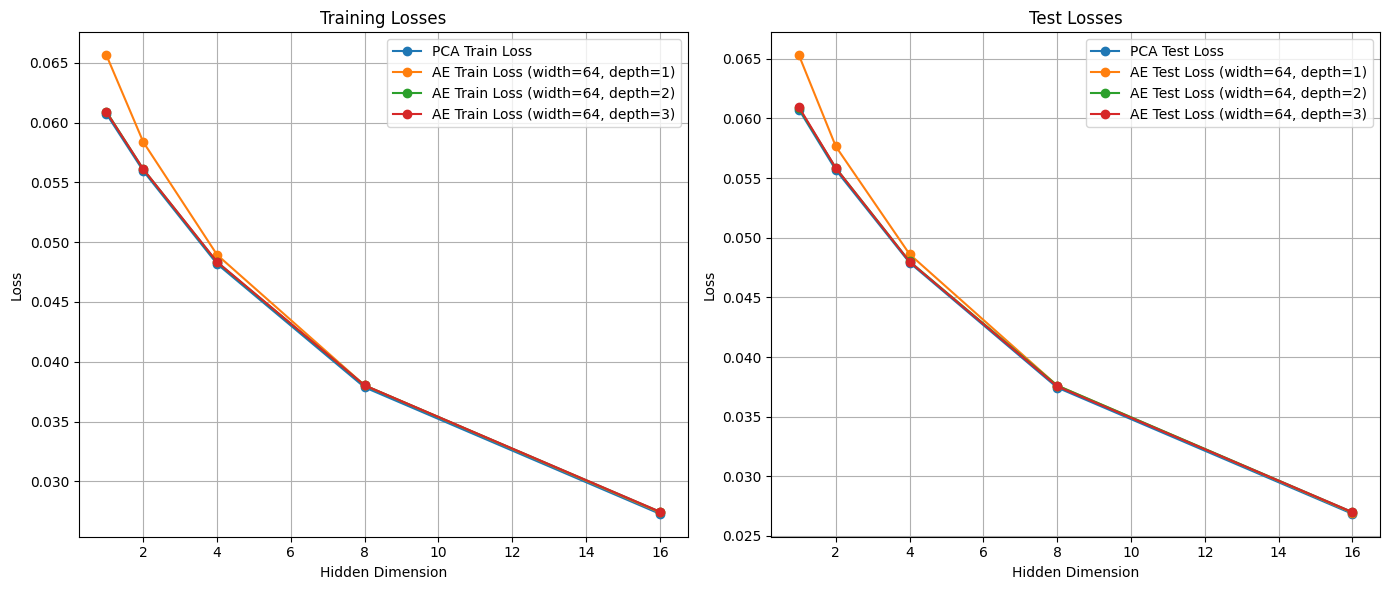

In [106]:
from collections import defaultdict

def plot_losses(pca_train_loss, pca_test_loss, ae_train_loss, ae_test_loss):
    """Plots the training and test losses for the PCA and autoencoder models.
    Produces two side-to-side plots for the train losses on the left 
    and the test losses on the right.

    Args:
        pca_train_loss (dict): Dictionary of PCA training losses
        pca_test_loss (dict): Dictionary of PCA test losses
        ae_train_loss (dict): Dictionary of autoencoder training losses (keys are tuples of (hidden_dim, width, depth))
        ae_test_loss (dict): Dictionary of autoencoder test losses (keys are tuples of (hidden_dim, width, depth))
    """
    # Create dictionaries to group the autoencoder losses by width and depth
    ae_train_grouped = defaultdict(list)
    ae_test_grouped = defaultdict(list)

    # Group losses by (width, depth) to have one curve per autoencoder model
    for (hidden_dim, width, depth), loss in ae_train_loss.items():
        ae_train_grouped[(width, depth)].append((hidden_dim, loss))

    for (hidden_dim, width, depth), loss in ae_test_loss.items():
        ae_test_grouped[(width, depth)].append((hidden_dim, loss))

    # Sort the losses by hidden_dim for each autoencoder model
    for key in ae_train_grouped:
        ae_train_grouped[key] = sorted(ae_train_grouped[key], key=lambda x: x[0])
    for key in ae_test_grouped:
        ae_test_grouped[key] = sorted(ae_test_grouped[key], key=lambda x: x[0])

    # Create a figure with two subplots, side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot PCA losses
    ax[0].plot(list(pca_train_loss.keys()), list(pca_train_loss.values()), label='PCA Train Loss', marker='o')
    ax[1].plot(list(pca_test_loss.keys()), list(pca_test_loss.values()), label='PCA Test Loss', marker='o')

    # Plot Autoencoder losses grouped by (width, depth)
    for (width, depth), values in ae_train_grouped.items():
        hidden_dims = [v[0] for v in values]
        losses = [v[1] for v in values]
        ax[0].plot(hidden_dims, losses, label=f'AE Train Loss (width={width}, depth={depth})', marker='o')

    for (width, depth), values in ae_test_grouped.items():
        hidden_dims = [v[0] for v in values]
        losses = [v[1] for v in values]
        ax[1].plot(hidden_dims, losses, label=f'AE Test Loss (width={width}, depth={depth})', marker='o')

    # Set titles and labels
    ax[0].set_title('Training Losses')
    ax[0].set_xlabel('Hidden Dimension')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].set_title('Test Losses')
    ax[1].set_xlabel('Hidden Dimension')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

plot_losses(pca_train_loss, pca_test_loss, ae_train_loss, ae_test_loss)

#### II.1.5. Conclusion
Think about the following questions, do not hesitate to call us (the teaching staff) for a brief discussion about them !
- Can we see any difference between a linear AE and PCA?
- Does increasing depth/width have an impact on the performance of the linear AE? Why?
- For the task of data compression, if you had to choose between PCA with $p$ principal components, or a linear AE with $p$ hidden dimensions, which model would you choose? What are the reasons behind your choice?

### II.2. Nonlinear AEs vs PCA
In this section we will compare the different non-linear AE models seen during the lesson to our PCA baseline. Indeed, if we are going to adopt an AE model for a given task, we will need to make sure that its performance is better than that of PCA, otherwise there is no point on adopting a more complex architecture.
The models we will evaluate are the following ones, seen during the lesson:
> - Undercomplete AE
> - Denoising AE
To keep it simple, we will omit the implementations of the sparse and contractive autoencoders.

Once more, we will perform a benchmarking experiment in order to evaluate the different AE models and compare them agains PCA and against each other.

Throughout this section, we will fix: 
- An array of hidden dimensions to test
- The depth of the AE architectures to be defined. 
- The width of the AE architectures to be defined.
- The batch size.
- The number of training epochs.

In [140]:
HIDDEN_DIMS = [1, 2, 4, 8, 16]
INPUT_DIM = 28*28
WIDTH = 128
DEPTH = 2
BATCH_SIZE = 64
EPOCHS = 5

For each of the models that we are studying, we will need to:
- Define the architecture.
- Train the model with different hyper-parameters.
- Select the hyper-parameters corresponding to the best model.
- Evaluate the model.

As it is customary in Deep Learning practice, the hyper-parameter optimization is done with the help of a validation set, therefore, we will split the test dataset into a validation dataset and a proper test dataset, and prepare the corresponding data loaders.

In [108]:
# Split test data into validation and test sets
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Exercice.** In order to perform the benchmark explained above, complete the following sections by addressing all the `TODO` flags in them:
1. Define a common architecture for both models.
2. Train and evaluate the undercomplete AE. Select the best model after hyper-parameter optimization if applies.
3. Train and evaluate the denoising AE. Select the best model after hyper-parameter optimization if applies.
7. Compare the performances (MSE loss) of the selected models (after hyper-parameter optimization) between each other and agains PCA.
8. Visualize the image reconstructions for both models and for PCA.

#### II.2.1. Architecture
**Question.** How many different architectures should we define ?

In [168]:
# TODO: Define a general autoencoder architecture with the fixed global parameters

class Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: Linear layer with ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(INPUT_DIM, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, hidden_dim),
            nn.ReLU()
        )

        # Decoder: Linear layer with Sigmoid activation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, INPUT_DIM),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input
        x = self.encoder(x)
        # Decode the latent representation
        x = self.decoder(x)
        return x

#### II.2.2. Undercomplete AE
**Question.** Are there any hyper-parameters involved in the training loss of an undercomplete AE?

In [169]:
# TODO: Train the undercomplete AE for the different hidden dimensions

# Store the models, along with training and validation losses
ucae_models = {} # Fpr visualization of image reconstructions
ucae_train_losses = {}
ucae_val_losses = {}
ucae_test_losses = {}

for p in HIDDEN_DIMS:
    print(f"Training undercomplete AE with {p} hidden dims")

    # Instantiate the model
    undercomplete_ae = Autoencoder(hidden_dim=p).to(device)

    # Set the criterion and optimizer
    criterion = nn.MSELoss() # Mean Squared Error loss
    optimizer = optim.Adam(undercomplete_ae.parameters(), lr=1e-3) # Adam optimizer

    for epoch in range(EPOCHS):
        undercomplete_ae.train()
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training loop
        for images in train_loader:
            # Move images to device
            images = images.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = undercomplete_ae(images)
            # Compute loss
            loss = criterion(outputs, images)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # Update running loss
            running_train_loss += loss.item() * images.size(0)
    
        # Compute average training loss for the epoch
        train_loss = running_train_loss  / len(train_loader.dataset)

        # Validation loop
        undercomplete_ae.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for validation
            for images in val_loader:
                # Move images to device
                images = images.to(device)
                # Forward pass
                outputs = undercomplete_ae(images)
                # Compute loss
                loss = criterion(outputs, images)
                # Accumulate validation loss
                running_val_loss += loss.item() * images.size(0)

        # Compute average validation loss for the epoch
        val_loss = running_val_loss / len(val_loader.dataset)

        # Print training and validation statistics for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Save the trained model and losses
    ucae_models[p] = undercomplete_ae
    ucae_train_losses[p] = train_loss
    ucae_val_losses[p] = val_loss

    # Evaluate the model on the test set
    undercomplete_ae.eval()  # Set model to evaluation mode
    running_test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images in test_loader:
            # Move images to device
            images = images.to(device)
            # Forward pass
            outputs = undercomplete_ae(images)
            # Compute loss
            loss = criterion(outputs, images)
            # Accumulate test loss
            running_test_loss += loss.item() * images.size(0)
    
    # Compute average test loss
    test_loss = running_test_loss / len(test_loader.dataset)
    ucae_test_losses[p] = test_loss

Training undercomplete AE with 1 hidden dims
Epoch [1/5], Training Loss: 0.0667, Validation Loss: 0.0622
Epoch [2/5], Training Loss: 0.0593, Validation Loss: 0.0580
Epoch [3/5], Training Loss: 0.0575, Validation Loss: 0.0572
Epoch [4/5], Training Loss: 0.0569, Validation Loss: 0.0565
Epoch [5/5], Training Loss: 0.0563, Validation Loss: 0.0561
Training undercomplete AE with 2 hidden dims
Epoch [1/5], Training Loss: 0.0671, Validation Loss: 0.0613
Epoch [2/5], Training Loss: 0.0603, Validation Loss: 0.0595
Epoch [3/5], Training Loss: 0.0590, Validation Loss: 0.0584
Epoch [4/5], Training Loss: 0.0580, Validation Loss: 0.0578
Epoch [5/5], Training Loss: 0.0575, Validation Loss: 0.0573
Training undercomplete AE with 4 hidden dims
Epoch [1/5], Training Loss: 0.0533, Validation Loss: 0.0445
Epoch [2/5], Training Loss: 0.0429, Validation Loss: 0.0418
Epoch [3/5], Training Loss: 0.0388, Validation Loss: 0.0367
Epoch [4/5], Training Loss: 0.0358, Validation Loss: 0.0351
Epoch [5/5], Training Los

#### II.2.3. Denoising AE
**Question.** Are there any new hyper-parameters involved in the training of the Denoising AE?

In [177]:
# TODO: Train the denoising AE with different noise levels

# Set the hyper-parameters
noise_levels = [0.003, 0.01, 0.03, 0.1]  # Noise levels to test

# Dictionaries to store the trained denoising models, train_losses and val_losses
denoising_models = {}
denoising_train_losses = {}
denoising_val_losses = {}
denoising_test_losses = {}

for p in HIDDEN_DIMS:
    for noise_level in noise_levels:
        print(f"Training denoising AE with {p} hidden dims and noise level {noise_level}")
        # Instantiate the model
        denoising_ae = Autoencoder(hidden_dim=p).to(device)

        # Set the criterion and optimizer
        criterion = nn.MSELoss() # Mean Squared Error loss
        optimizer = optim.Adam(denoising_ae.parameters(), lr=1e-3) # Adam optimizer

        num_epochs = EPOCHS

        for epoch in range(num_epochs):
            denoising_ae.train()
            running_train_loss = 0.0
            running_val_loss = 0.0

            # Training loop
            for images in train_loader:
                # Move images to device
                images = images.to(device) 
                # Generate noisy images with the given noise level
                noisy_images = images + noise_level * torch.randn_like(images)
                # Clip pixel values to [0, 1]
                noisy_images = torch.clamp(noisy_images, 0, 1) 
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = denoising_ae(noisy_images)
                # Compute loss
                loss = criterion(outputs, images)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Accumulate training loss
                running_train_loss += loss.item() * images.size(0)
            
            # Compute average training loss for the epoch
            train_loss = running_train_loss / len(train_loader.dataset)

            # Validation loop
            denoising_ae.eval()  # Set model to evaluation mode
            with torch.no_grad():  # Disable gradient calculation for validation
                for images in val_loader:
                    # Move images to device
                    images = images.to(device)
                    # Generate noisy images with the given noise level
                    noisy_images = images + noise_level * torch.randn_like(images)
                    # Clip pixel values to [0, 1]
                    noisy_images = torch.clamp(noisy_images, 0, 1) 
                    # Forward pass
                    outputs = denoising_ae(noisy_images)
                    # Compute loss
                    loss = criterion(outputs, images)
                    # Accumulate validation loss
                    running_val_loss += loss.item() * images.size(0)

            # Compute average validation loss for the epoch
            val_loss = running_val_loss / len(val_loader.dataset)

            # Print training and validation statistics for the epoch
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Save model and losses
        denoising_models[(p, noise_level)] = denoising_ae
        denoising_train_losses[(p, noise_level)] = train_loss
        denoising_val_losses[(p, noise_level)] = val_loss

        # Evaluate the model on the test set
        denoising_ae.eval()  # Set model to evaluation mode
        running_test_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for images in test_loader:
                # Move images to device
                images = images.to(device)
                # Forward pass
                outputs = denoising_ae(images)
                # Compute loss
                loss = criterion(outputs, images)
                # Accumulate test loss
                running_test_loss += loss.item() * images.size(0)
        
        # Compute average test loss
        test_loss = running_test_loss / len(test_loader.dataset)
        print(test_loss)
        denoising_test_losses[(p, noise_level)] = test_loss
        

Training denoising AE with 1 hidden dims and noise level 0.003
Epoch [1/5], Training Loss: 0.0656, Validation Loss: 0.0609
Epoch [2/5], Training Loss: 0.0587, Validation Loss: 0.0578
Epoch [3/5], Training Loss: 0.0573, Validation Loss: 0.0570
Epoch [4/5], Training Loss: 0.0566, Validation Loss: 0.0562
Epoch [5/5], Training Loss: 0.0560, Validation Loss: 0.0557
0.055230335092544554
Training denoising AE with 1 hidden dims and noise level 0.01
Epoch [1/5], Training Loss: 0.0726, Validation Loss: 0.0678
Epoch [2/5], Training Loss: 0.0674, Validation Loss: 0.0677
Epoch [3/5], Training Loss: 0.0673, Validation Loss: 0.0678
Epoch [4/5], Training Loss: 0.0673, Validation Loss: 0.0677
Epoch [5/5], Training Loss: 0.0673, Validation Loss: 0.0677
0.06738640818595887
Training denoising AE with 1 hidden dims and noise level 0.03
Epoch [1/5], Training Loss: 0.0718, Validation Loss: 0.0677
Epoch [2/5], Training Loss: 0.0674, Validation Loss: 0.0677
Epoch [3/5], Training Loss: 0.0674, Validation Loss:

#### II.2.4. Loss plots

In [178]:
# Train PCA

pca_train_losses = {}
pca_val_losses = {}
pca_test_losses = {}

for p in HIDDEN_DIMS:
    print(f"Training PCA model with {p} hidden dims")

    # Train the PCA model
    pca = train_pca(p)

    # Evaluate the PCA model on the training and validation data
    pca_reconstruction_train = pca.inverse_transform(pca.transform(train_dataset))
    pca_reconstruction_val = pca.inverse_transform(pca.transform(val_dataset))
    pca_reconstruction_test = pca.inverse_transform(pca.transform(test_dataset))

    mse_train_pca = mean_squared_error(train_dataset, pca_reconstruction_train)
    mse_val_pca = mean_squared_error(val_dataset, pca_reconstruction_val)
    mse_test_pca = mean_squared_error(test_dataset, pca_reconstruction_test)
    print(f"Train MSE: {mse_train_pca}, Validation MSE: {mse_val_pca}")

    pca_train_losses[p] = mse_train_pca
    pca_val_losses[p] = mse_val_pca
    pca_test_losses[p] = mse_test_pca

Training PCA model with 1 hidden dims


Train MSE: 0.060724806346546686, Validation MSE: 0.06089357245956402
Training PCA model with 2 hidden dims
Train MSE: 0.05595270364213887, Validation MSE: 0.055704556979195415
Training PCA model with 4 hidden dims
Train MSE: 0.048179454093877486, Validation MSE: 0.04798237063803697
Training PCA model with 8 hidden dims
Train MSE: 0.03786521729268966, Validation MSE: 0.03757613063372446
Training PCA model with 16 hidden dims
Train MSE: 0.027292815829186662, Validation MSE: 0.026876789993386448


In [179]:
# Create dictionaries to group the denoising AE losses by noise level
denoising_train_grouped = defaultdict(list)
denoising_val_grouped = defaultdict(list)

# Group losses by noise level to have one curve per denoising model
for (hidden_dim, noise_level), loss in denoising_train_losses.items():
    denoising_train_grouped[noise_level].append((hidden_dim, loss))
for (hidden_dim, noise_level), loss in denoising_val_losses.items():
    denoising_val_grouped[noise_level].append((hidden_dim, loss))

# Sort the losses by hidden_dim for each denoising model
for key in denoising_train_grouped:
    denoising_train_grouped[key] = sorted(denoising_train_grouped[key], key=lambda x: x[0])
for key in denoising_val_grouped:
    denoising_val_grouped[key] = sorted(denoising_val_grouped[key], key=lambda x: x[0])

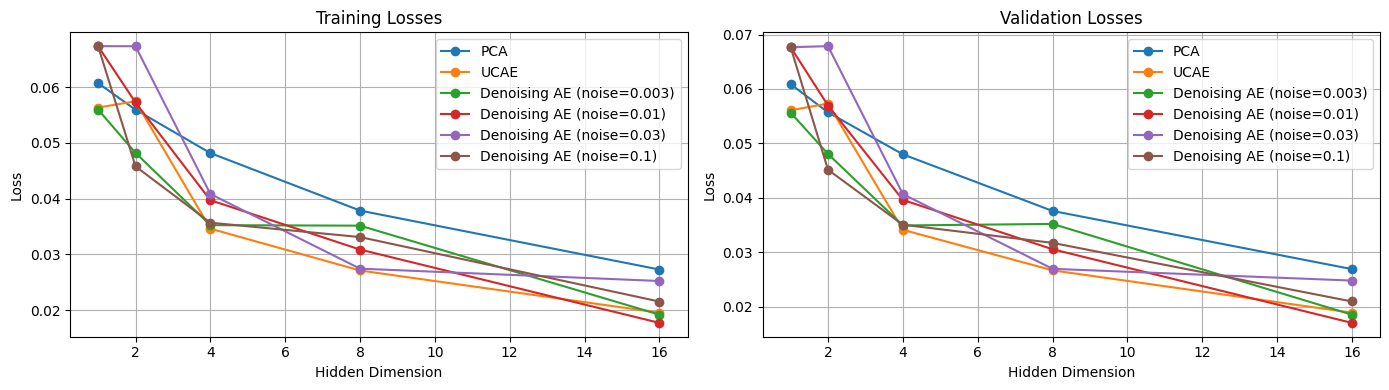

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
#fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot PCA losses
ax[0].plot(list(pca_train_losses.keys()), list(pca_train_losses.values()), label='PCA', marker='o')
ax[1].plot(list(pca_val_losses.keys()), list(pca_val_losses.values()), label='PCA', marker='o')
#ax[2].plot(list(pca_test_loss.keys()), list(pca_test_loss.values()), label='PCA', marker='o')

# Plot undercomplete AE losses
ax[0].plot(list(ucae_train_losses.keys()), list(ucae_train_losses.values()), label='UCAE', marker='o')
ax[1].plot(list(ucae_val_losses.keys()), list(ucae_val_losses.values()), label='UCAE', marker='o')
#ax[2].plot(list(ucae_test_losses.keys()), list(ucae_test_losses.values()), label='UCAE', marker='o')

# Plot denoising AE losses
for noise_level, values in denoising_train_grouped.items():
    hidden_dims = [v[0] for v in values]
    losses = [v[1] for v in values]
    ax[0].plot(hidden_dims, losses, label=f'Denoising AE (noise={noise_level})', marker='o')

for noise_level, values in denoising_val_grouped.items():
    hidden_dims = [v[0] for v in values]
    losses = [v[1] for v in values]
    ax[1].plot(hidden_dims, losses, label=f'Denoising AE (noise={noise_level})', marker='o')

# Set titles and labels
ax[0].set_title('Training Losses')
ax[0].set_xlabel('Hidden Dimension')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('Validation Losses')
ax[1].set_xlabel('Hidden Dimension')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [181]:
# TODO: Extract the test losses for the best denoising AE models
# i.e. the best noise level for each hidden dimension, 
# chosen according to the validation loss.

# Dictionary to store the best test losses and their corresponding noise levels
best_test_losses = {}

# Iterate over hidden dimensions and select the best model based on validation loss
for p in HIDDEN_DIMS:
    # Find the noise level that has the minimum validation loss for the current hidden dimension
    best_noise_level = min(
        [noise_level for noise_level in noise_levels],
        key=lambda nl: denoising_val_losses[(p, nl)]
    )

    # Retrieve the best model, train loss, and validation loss for the selected noise level
    best_test_loss = denoising_test_losses[(p, best_noise_level)]
    best_train_loss = denoising_train_losses[(p, best_noise_level)]
    best_val_loss = denoising_val_losses[(p, best_noise_level)]
    best_test_losses[p] = best_test_loss

    # Print out the best models, their noise levels, and the corresponding losses
    print(f"Best model for hidden dimension {p}:")
    print(f"Noise level: {best_noise_level}")
    print(f"Train loss: {best_train_loss}")
    print(f"Validation loss: {best_val_loss}")
    print(f"Test loss: {best_test_loss}")

Best model for hidden dimension 1:
Noise level: 0.003
Train loss: 0.0559734082976977
Validation loss: 0.055660913842916486
Test loss: 0.055230335092544554
Best model for hidden dimension 2:
Noise level: 0.1
Train loss: 0.0457922139664491
Validation loss: 0.04514317787885666
Test loss: 0.048887765914201735
Best model for hidden dimension 4:
Noise level: 0.003
Train loss: 0.03525239668091138
Validation loss: 0.03490237142443657
Test loss: 0.0347332160115242
Best model for hidden dimension 8:
Noise level: 0.03
Train loss: 0.027451094886660577
Validation loss: 0.02693106366097927
Test loss: 0.026862580141425133
Best model for hidden dimension 16:
Noise level: 0.01
Train loss: 0.017727401742339135
Validation loss: 0.016990123835206032
Test loss: 0.01705557754188776


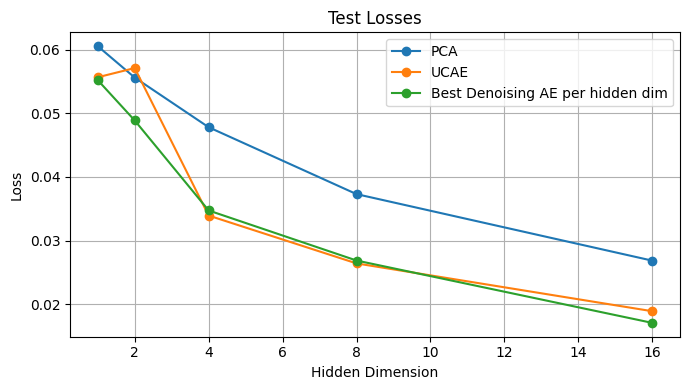

In [182]:
# Plot test losses for PCA, UCAE, and best denoising AEs

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# Plot PCA test loss
ax.plot(list(pca_test_losses.keys()), list(pca_test_losses.values()), label='PCA', marker='o')

# Plot undercomplete AE test loss
ax.plot(list(ucae_test_losses.keys()), list(ucae_test_losses.values()), label='UCAE', marker='o')

# Plot best denoising AE test loss
ax.plot(list(best_test_losses.keys()), list(best_test_losses.values()), label='Best Denoising AE per hidden dim', marker='o')

# Set titles and labels
ax.set_title('Test Losses')
ax.set_xlabel('Hidden Dimension')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### II.2.5. Visualization of reconstructions

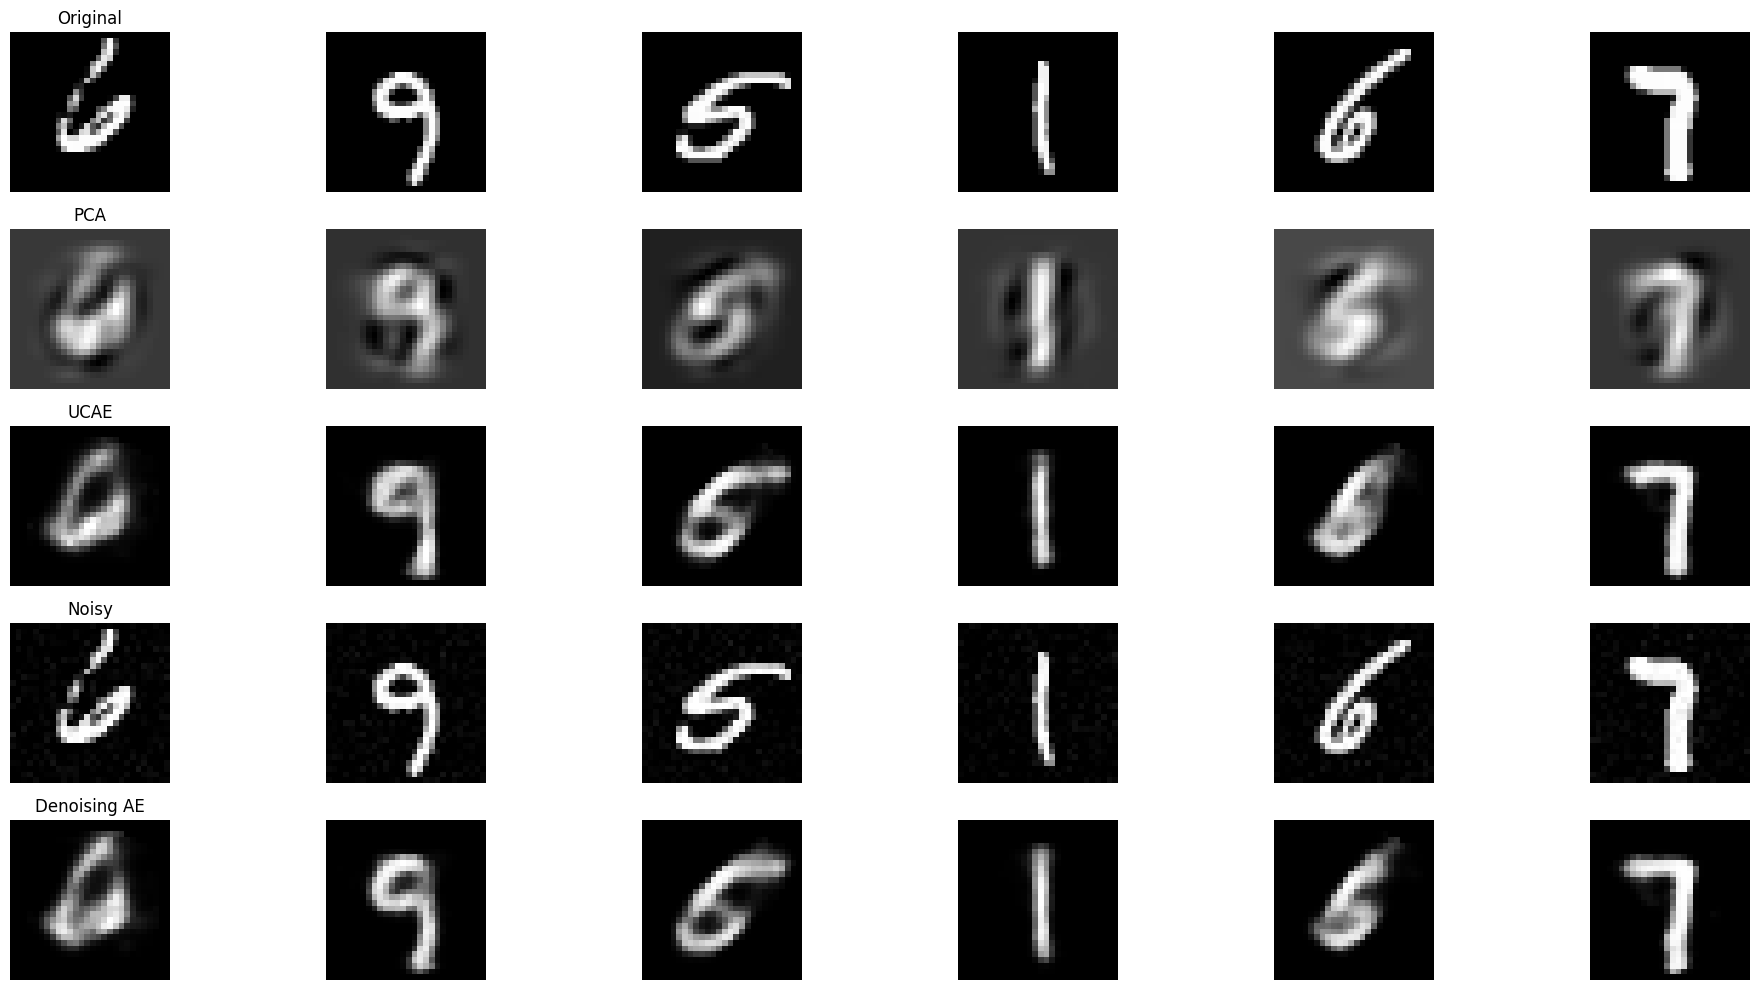

In [188]:
# TODO: Visualize the image reconstructions for 
# PCA, UCAE, and the best denoising AE model for hidden_dim=8

# Get the best denoising AE model for hidden_dim=8
denoising_model = denoising_models[(8, 0.03)]

# Get a batch of test images
images = next(iter(test_loader))
images = images.to(device)

# Generate noisy images
noisy_images = images + 0.03 * torch.randn_like(images)
noisy_images = torch.clamp(noisy_images, 0, 1)

# Reconstruct images using the models
pca_reconstruction = pca.inverse_transform(pca.transform(images.view(images.size(0), -1).cpu().numpy()))
ucae_reconstruction = ucae_models[8](images.view(images.size(0), -1)).cpu().detach().numpy()
denoising_reconstruction = denoising_model(noisy_images.view(noisy_images.size(0), -1)).cpu().detach().numpy()

# Reshape images for plotting to (batch_size, 28, 28)
images = images.cpu().numpy().reshape(-1, 28, 28)
noisy_images = noisy_images.cpu().numpy().reshape(-1, 28, 28)
pca_reconstruction = pca_reconstruction.reshape(-1, 28, 28)
ucae_reconstruction = ucae_reconstruction.reshape(-1, 28, 28)
denoising_reconstruction = denoising_reconstruction.reshape(-1, 28, 28)


# Plot the original, PCA, UCAE, noisy, and denoising AE reconstructed images
fig, ax = plt.subplots(5, 6, figsize=(20, 10))

for i in range(6):
    # Original images
    ax[0, i].imshow(images[i], cmap='gray')
    ax[0, i].axis('off')
    ax[0, 0].set_title('Original')

    # PCA reconstructed images
    ax[1, i].imshow(pca_reconstruction[i], cmap='gray')
    ax[1, i].axis('off')
    ax[1, 0].set_title('PCA')

    # UCAE reconstructed images
    ax[2, i].imshow(ucae_reconstruction[i], cmap='gray')
    ax[2, i].axis('off')
    ax[2, 0].set_title('UCAE')

    # Noisy images
    ax[3, i].imshow(noisy_images[i], cmap='gray')
    ax[3, i].axis('off')
    ax[3, 0].set_title('Noisy')

    # Denoising AE reconstructed images
    ax[4, i].imshow(denoising_reconstruction[i], cmap='gray')
    ax[4, i].axis('off')
    ax[4, 0].set_title('Denoising AE')

plt.tight_layout()
plt.show()

## Image Generation with VAEs

## Image interpolation

## Visualization of the latent space

## Transferable representations